In [1]:
import re
from collections import OrderedDict

l = [
 'Euclidean','Cosine','Pearson','Spearman','Minkowski','Canberra','Chebyshev',
 'alpha_ReQ_a1','alpha_ReQ_a2','alpha_ReQ_A1','alpha_ReQ_A2',
 'NESum_a1','NESum_a2','NESum_A1','NESum_A2',
 'RankMe_a1','RankMe_a2','RankMe_A1','RankMe_A2',
 'StableRank_a1','StableRank_a2','StableRank_A1','StableRank_A2',
 'SelfCluster_a1','SelfCluster_a2','SelfCluster_A1','SelfCluster_A2',
 'h0_count_A1','h1_count_A1','h0_max_lifetime_A1','h1_max_lifetime_A1',
 'euclidean_entropy_H0_A1','euclidean_entropy_H1_A1',
 'h0_count_A2','h1_count_A2','h0_max_lifetime_A2','h1_max_lifetime_A2',
 'euclidean_entropy_H0_A2','euclidean_entropy_H1_A2',
 'h0_count_a1','h1_count_a1','h0_max_lifetime_a1','h1_max_lifetime_a1',
 'euclidean_entropy_H0_a1','euclidean_entropy_H1_a1',
 'h0_count_a2','h1_count_a2','h0_max_lifetime_a2','h1_max_lifetime_a2',
 'euclidean_entropy_H0_a2','euclidean_entropy_H1_a2',
 'h0_count_a1_a2','h1_count_a1_a2','h0_max_lifetime_a1_a2','h1_max_lifetime_a1_a2',
 'euclidean_entropy_H0_a1_a2','euclidean_entropy_H1_a1_a2',
 'euclidean_bottleneck_a1_a2','euclidean_wasserstein_a1_a2',
 'euclidean_bottleneck_A1_A2','euclidean_wasserstein_A1_A2',
 'cosine_entropy_H0_A1','cosine_entropy_H1_A1','cosine_entropy_H0_A2','cosine_entropy_H1_A2',
 'cosine_entropy_H0_a1','cosine_entropy_H1_a1','cosine_entropy_H0_a2','cosine_entropy_H1_a2',
 'cosine_entropy_H0_a1_a2','cosine_entropy_H1_a1_a2',
 'cosine_bottleneck_a1_a2','cosine_wasserstein_a1_a2',
 'cosine_bottleneck_A1_A2','cosine_wasserstein_A1_A2',
 'manhattan_entropy_H0_A1','manhattan_entropy_H1_A1','manhattan_entropy_H0_A2','manhattan_entropy_H1_A2',
 'manhattan_entropy_H0_a1','manhattan_entropy_H1_a1','manhattan_entropy_H0_a2','manhattan_entropy_H1_a2',
 'manhattan_entropy_H0_a1_a2','manhattan_entropy_H1_a1_a2',
 'manhattan_bottleneck_a1_a2','manhattan_wasserstein_a1_a2',
 'manhattan_bottleneck_A1_A2','manhattan_wasserstein_A1_A2',
 'syn_len_a','syn_len_b','syn_equal_exact','syn_equal_casefold',
 'syn_contains_a_in_b','syn_contains_b_in_a',
 'syn_levenshtein','syn_levenshtein_sim','syn_damerau_osa','syn_damerau_osa_sim',
 'syn_lcs_len','syn_lcs_ratio','syn_common_prefix_ratio','syn_common_suffix_ratio',
 'syn_jaccard_tokens','syn_dice_tokens','syn_jaccard_bigrams','syn_jaccard_trigrams',
 'syn_cosine_bigrams','syn_cosine_trigrams','syn_jaro','syn_jaro_winkler',
]

# ---------- Core tag maps ----------
classical_core = {
    'Euclidean': 'Eucl', 'Cosine': 'Cos', 'Pearson': 'Pear', 'Spearman': 'Spea',
    'Minkowski': 'Mink', 'Canberra': 'Canb', 'Chebyshev': 'Cheb',
}
spectral_core = {
    'alpha_ReQ': 'aRQ', 'NESum': 'NES', 'RankMe': 'RM', 'StableRank': 'SR', 'SelfCluster': 'SC',
}
# Topological grounds and invariants (core tags)
grounds = {'euclidean': 'euc', 'cosine': 'cos', 'manhattan': 'man'}
entropy_op = {'H0': 'E0', 'H1': 'E1'}
inv_core = {('h','0','count'): 'h0c', ('h','1','count'): 'h1c',
            ('h','0','max_lifetime'): 'h0ml', ('h','1','max_lifetime'): 'h1ml'}

# Syntactic (treated as classical core family)
syn_core = {
    'len_a': 'len_a', 'len_b': 'len_b',
    'equal_exact': 'eq_ab', 'equal_casefold': 'eqcf_ab',
    'contains_a_in_b': 'in_a_in_b', 'contains_b_in_a': 'in_b_in_a',
    'levenshtein': 'lev_ab', 'levenshtein_sim': 'levS_ab',
    'damerau_osa': 'dosa_ab', 'damerau_osa_sim': 'dosaS_ab',
    'lcs_len': 'lcsL_ab', 'lcs_ratio': 'lcsR_ab',
    'common_prefix_ratio': 'cprefR_ab', 'common_suffix_ratio': 'csuffR_ab',
    'jaccard_tokens': 'jacTok_ab', 'dice_tokens': 'diceTok_ab',
    'jaccard_bigrams': 'jacBG_ab', 'jaccard_trigrams': 'jacTG_ab',
    'cosine_bigrams': 'cosBG_ab', 'cosine_trigrams': 'cosTG_ab',
    'jaro': 'jaro_ab', 'jaro_winkler': 'JW_ab',
}

# ---------- Scope conversion ----------
def scope_map(token: str) -> str:
    return {
        'A1': 'E1', 'A2': 'E2',
        'a1': 'P1', 'a2': 'P2',
        'a1_a2': 'P1P2', 'A1_A2': 'E1E2',
        'E1': 'E1', 'E2': 'E2', 'P1': 'P1', 'P2': 'P2',
        'a': 'a', 'b': 'b', 'ab': 'ab'
    }[token]

# ---------- Abbreviation engine ----------
def abbreviate(name: str) -> str:
    if name in classical_core:
        return classical_core[name]

    m = re.match(r'^(alpha_ReQ|NESum|RankMe|StableRank|SelfCluster)_(A1|A2|a1|a2)$', name)
    if m:
        core = spectral_core[m.group(1)]
        sc = scope_map(m.group(2))
        return f'{core}_{sc}'

    m = re.match(r'^(h)([01])_(count|max_lifetime)_(A1|A2|a1|a2|a1_a2|A1_A2)$', name)
    if m:
        core = inv_core[(m.group(1), m.group(2), m.group(3))]
        sc = scope_map(m.group(4))
        return f'{core}_{sc}'

    m = re.match(r'^(euclidean|cosine|manhattan)_entropy_(H[01])_(A1|A2|a1|a2|a1_a2|A1_A2)$', name)
    if m:
        g, H, sc_tok = m.groups()
        core = grounds[g] + entropy_op[H]
        sc = scope_map(sc_tok)
        return f'{core}_{sc}'

    m = re.match(r'^(euclidean|cosine|manhattan)_(bottleneck|wasserstein)_(a1_a2|A1_A2)$', name)
    if m:
        g, op, sc_tok = m.groups()
        op_tag = 'B' if op == 'bottleneck' else 'W'
        core = grounds[g] + op_tag
        sc = scope_map(sc_tok)
        return f'{core}_{sc}'

    if name.startswith('syn_'):
        syn = name[len('syn_'):]
        # special cases with _a / _b
        if syn in ('len_a','len_b'):
            return syn_core[syn]
        if syn in ('equal_exact','equal_casefold','levenshtein','levenshtein_sim',
                   'damerau_osa','damerau_osa_sim','lcs_len','lcs_ratio',
                   'common_prefix_ratio','common_suffix_ratio',
                   'jaccard_tokens','dice_tokens','jaccard_bigrams','jaccard_trigrams',
                   'cosine_bigrams','cosine_trigrams','jaro','jaro_winkler'):
            return syn_core[syn]
        if syn in ('contains_a_in_b','contains_b_in_a'):
            return syn_core[syn]

    raise ValueError(f"Unrecognized feature pattern: {name}")

# ---------- Build ordered mapping ----------
abbr = OrderedDict((name, abbreviate(name)) for name in l)


assert abbr['Euclidean'] == 'Eucl'
assert abbr['alpha_ReQ_a1'] == 'aRQ_P1'
assert abbr['NESum_A2'] == 'NES_E2'
assert abbr['h0_count_a1_a2'] == 'h0c_P1P2'
assert abbr['euclidean_entropy_H0_A1'] == 'eucE0_E1'
assert abbr['euclidean_bottleneck_A1_A2'] == 'eucB_E1E2'
assert abbr['syn_len_a'] == 'len_a'
assert abbr['syn_equal_casefold'] == 'eqcf_ab'


In [2]:
l=[
 'Euclidean',
 'Cosine',
 'Pearson',
 'Spearman',
 'Minkowski',
 'Canberra',
 'Chebyshev',
 'alpha_ReQ_a1',
 'alpha_ReQ_a2',
 'alpha_ReQ_A1',
 'alpha_ReQ_A2',
 'NESum_a1',
 'NESum_a2',
 'NESum_A1',
 'NESum_A2',
 'RankMe_a1',
 'RankMe_a2',
 'RankMe_A1',
 'RankMe_A2',
 'StableRank_a1',
 'StableRank_a2',
 'StableRank_A1',
 'StableRank_A2',
 'SelfCluster_a1',
 'SelfCluster_a2',
 'SelfCluster_A1',
 'SelfCluster_A2',
 'h0_count_A1',
 'h1_count_A1',
 'h0_max_lifetime_A1',
 'h1_max_lifetime_A1',
 'euclidean_entropy_H0_A1',
 'euclidean_entropy_H1_A1',
 'h0_count_A2',
 'h1_count_A2',
 'h0_max_lifetime_A2',
 'h1_max_lifetime_A2',
 'euclidean_entropy_H0_A2',
 'euclidean_entropy_H1_A2',
 'h0_count_a1',
 'h1_count_a1',
 'h0_max_lifetime_a1',
 'h1_max_lifetime_a1',
 'euclidean_entropy_H0_a1',
 'euclidean_entropy_H1_a1',
 'h0_count_a2',
 'h1_count_a2',
 'h0_max_lifetime_a2',
 'h1_max_lifetime_a2',
 'euclidean_entropy_H0_a2',
 'euclidean_entropy_H1_a2',
 'h0_count_a1_a2',
 'h1_count_a1_a2',
 'h0_max_lifetime_a1_a2',
 'h1_max_lifetime_a1_a2',
 'euclidean_entropy_H0_a1_a2',
 'euclidean_entropy_H1_a1_a2',
 'euclidean_bottleneck_a1_a2',
 'euclidean_wasserstein_a1_a2',
 'euclidean_bottleneck_A1_A2',
 'euclidean_wasserstein_A1_A2',
 'cosine_entropy_H0_A1',
 'cosine_entropy_H1_A1',
 'cosine_entropy_H0_A2',
 'cosine_entropy_H1_A2',
 'cosine_entropy_H0_a1',
 'cosine_entropy_H1_a1',
 'cosine_entropy_H0_a2',
 'cosine_entropy_H1_a2',
 'cosine_entropy_H0_a1_a2',
 'cosine_entropy_H1_a1_a2',
 'cosine_bottleneck_a1_a2',
 'cosine_wasserstein_a1_a2',
 'cosine_bottleneck_A1_A2',
 'cosine_wasserstein_A1_A2',
 'manhattan_entropy_H0_A1',
 'manhattan_entropy_H1_A1',
 'manhattan_entropy_H0_A2',
 'manhattan_entropy_H1_A2',
 'manhattan_entropy_H0_a1',
 'manhattan_entropy_H1_a1',
 'manhattan_entropy_H0_a2',
 'manhattan_entropy_H1_a2',
 'manhattan_entropy_H0_a1_a2',
 'manhattan_entropy_H1_a1_a2',
 'manhattan_bottleneck_a1_a2',
 'manhattan_wasserstein_a1_a2',
 'manhattan_bottleneck_A1_A2',
 'manhattan_wasserstein_A1_A2',
 'syn_len_a',
 'syn_len_b',
 'syn_equal_exact',
 'syn_equal_casefold',
 'syn_contains_a_in_b',
 'syn_contains_b_in_a',
 'syn_levenshtein',
 'syn_levenshtein_sim',
 'syn_damerau_osa',
 'syn_damerau_osa_sim',
 'syn_lcs_len',
 'syn_lcs_ratio',
 'syn_common_prefix_ratio',
 'syn_common_suffix_ratio',
 'syn_jaccard_tokens',
 'syn_dice_tokens',
 'syn_jaccard_bigrams',
 'syn_jaccard_trigrams',
 'syn_cosine_bigrams',
 'syn_cosine_trigrams',
 'syn_jaro',
 'syn_jaro_winkler',
]
len(l) 

111

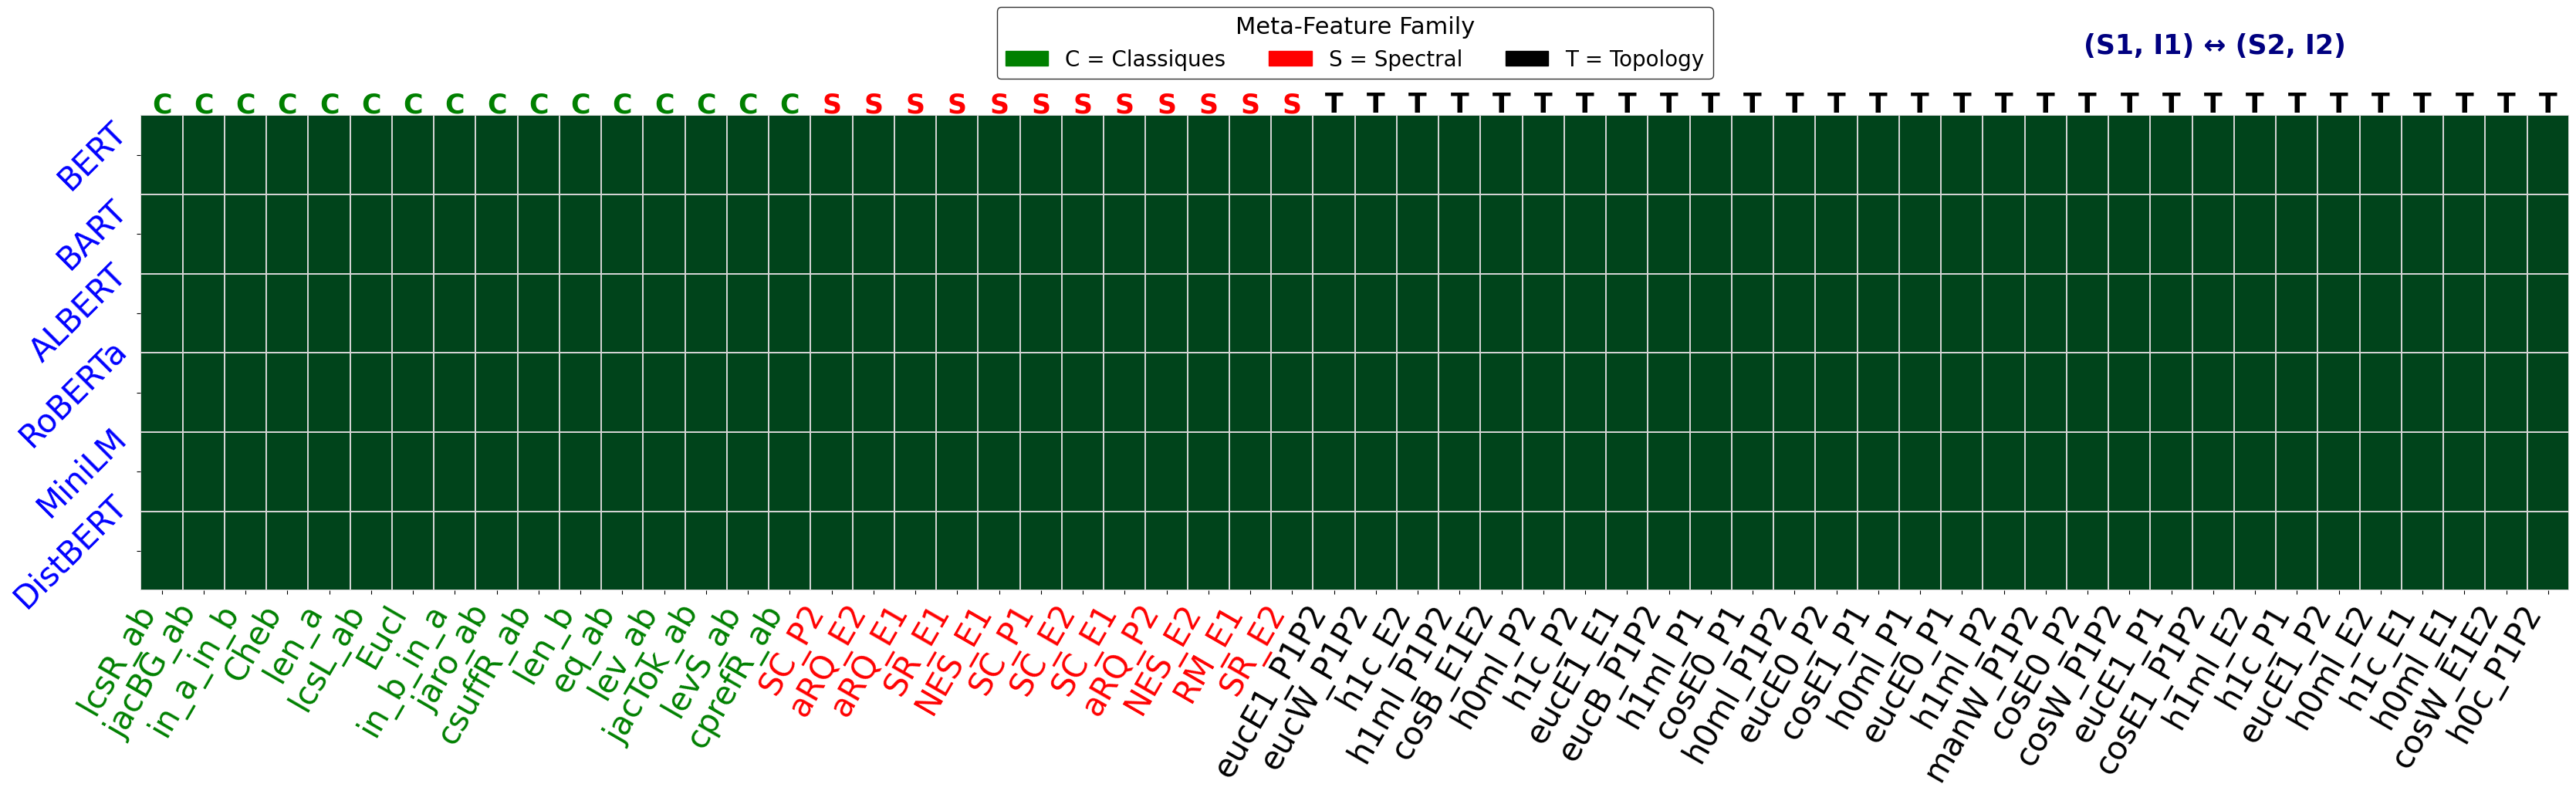

<Figure size 640x480 with 0 Axes>

In [3]:

# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
import re
import json

import sys
from pathlib import Path
import ipynbname
ROOT = Path(ipynbname.path()).resolve().parents[1]
# ========= PARAMÈTRES =========
scenario = "si_si"  # ⚡ tu changes ici pour ton scénario
input_json = ROOT / "RQ4_Feature_Selection/features_all_models.json"
mapping_outfile =  ROOT / "RQ4_Feature_Selection/figures/abbr_mapping.json"
figure_outfile =  ROOT / "RQ4_Feature_Selection/figures/features_abbr.png"

with open(input_json, "r") as f:
    features_dict = json.load(f)

def group_features(columns):
    """Classe les features en familles : Classiques, Spectral, Topology."""
    families = {"Classiques": [], "Spectral": [], "Topology": []}
    for c in columns:
        if c.startswith('syn') or c=='Euclidean'or c=='Cosine'or c=='Pearson'or c=='Spearman'or c=='Minkowski'or c=='Canberra'or c=='Chebyshev':
            families["Classiques"].append(c)
        elif c.startswith(("alpha_ReQ", "NESum", "RankMe", "StableRank", "SelfCluster")):
            families["Spectral"].append(c)
        else:
            families["Topology"].append(c)
    return families

# ========= COULEURS =========
category_colors = {
    "Classiques": "green",
    "Spectral": "red",
    "Topology": "black",
}

# ========= TRANSFORMER EN MATRICE =========
# Liste unique de tous les features
all_features = sorted(set(sum(features_dict.values(), [])))

# Construire DataFrame binaire (1 = feature présent, 0 = absent)
heatmap_df_norm = pd.DataFrame(0, index=features_dict.keys(), columns=all_features)
for model, feats in features_dict.items():
    heatmap_df_norm.loc[model, feats] = 1

norm = heatmap_df_norm.columns
heatmap_df_norm = heatmap_df_norm.loc[:, ~norm.duplicated(keep='first')]
# Retirer les colonnes non-features
NON_FEATURE_COLS = {
    "Attribute1", "Attribute2", "true_match", "Category", "Relation",
    "Dataset", "Model", "ExecutionTime", "Scenario"
}
scenarios = {
    "si_si": "(S1, I1) ↔ (S2, I2)",        
}
MODEL_NAMES = {
    "bert": "BERT",
    "bart": "BART",
    "albert": "ALBERT",
    "roberta": "RoBERTa",
    "minilm": "MiniLM",
    "distilbert": "DistBERT"
}
feature_columns = set([c for c in heatmap_df_norm.columns if c not in NON_FEATURE_COLS])
# Groupement et ordre
families = group_features(feature_columns)
ordered_features = families["Classiques"] + families["Spectral"] + families["Topology"]
ordered_features = list(dict.fromkeys(ordered_features))  # ⚡ supprime doublons
abbr_list = [abbreviate(f) for f in ordered_features]

# DataFrame restreint
df_plot = heatmap_df_norm[ordered_features].copy()

df_plot.columns = abbr_list
df_plot.index=[MODEL_NAMES[m] for m in df_plot.index]
# ========= FIGURE =========
n_features = df_plot.shape[1]
fig_width = max(18, n_features * 0.7)
n_models = df_plot.shape[0]
fig_height = max(2, n_models * 0.5)+5  # 0.5 pouce par ligne
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.heatmap(
    df_plot,
    cmap="Greens",
    cbar=False,
    linewidths=0.2,
    linecolor="lightgray",
    ax=ax
)


for i, feat in enumerate(ordered_features):
    if feat in families["Classiques"]:
        cat = "Classiques"
    elif feat in families["Spectral"]:
        cat = "Spectral"
    else:
        cat = "Topology"

    ax.text(
        i + 0.5,
        -0.3,
        cat[0],
        ha="center", va="top",
        fontsize=25,
        color=category_colors[cat],
        fontweight="bold"
    )

# Colorier labels X selon famille
for tick_label, feat in zip(ax.get_xticklabels(), ordered_features):
    if feat in families["Classiques"]:
        tick_label.set_color(category_colors["Classiques"])
    elif feat in families["Spectral"]:
        tick_label.set_color(category_colors["Spectral"])
    else:
        tick_label.set_color(category_colors["Topology"])

# Légende
legend_patches = [
    mpatches.Patch(color='green', label='C = Classiques'),
    mpatches.Patch(color='red', label='S = Spectral'),
    mpatches.Patch(color='black', label='T = Topology'),
]
leg = ax.legend(
    handles=legend_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=3,
    frameon=True,
    fontsize=20,
    title="Meta-Feature Family",
    title_fontsize=22
)
leg.get_frame().set_edgecolor('black')


ax.text(
    0.8, 1.13,               
    f"{scenarios[scenario]}",  
    transform=ax.transAxes,   
    fontsize=25,
    fontweight="bold",
    color="navy"
)
sns.heatmap(
    df_plot,
    cmap="Greens",
    cbar=False,
    linewidths=0.2,
    linecolor="lightgray",
    ax=ax,
    vmin=0, vmax=1,
    annot=False, fmt="d"
)
# Grands textes
ax.set_xticklabels(df_plot.columns, rotation=60, ha="right", fontsize=30)
ax.set_yticklabels(df_plot.index, rotation=45, fontsize=30, color="blue")

fig_width = max(5, n_features * 0.7)


plt.show()
plt.savefig(figure_outfile, dpi=350, bbox_inches="tight")


In [4]:
abr='si_si'
def format_latex(mean, std):
    return f"${mean:.2f}\\pm{std:.2f}$"
path      = ROOT / "RQ4_Feature_Selection" / "58_mt_effectiveness.csv" 
df = pd.read_csv(path)


# Calcul des moyennes et écarts-types
grouped = df.groupby(['classifier', 'embedding_model']).agg(
    mean_precision=('precision', 'mean'),
    std_precision=('precision', 'std'),
    mean_recall=('recall', 'mean'),
    std_recall=('recall', 'std'),
    mean_f1=('f1', 'mean'),
    std_f1=('f1', 'std')
).reset_index()

embeddings = grouped['embedding_model'].unique()

# Construire LaTeX à la main (style demandé)
header = (
    "\\begin{table}[!ht]\n"
    "\\footnotesize\n"
    "\\centering\n"
    f"\\caption{{Precision, Recall, and F1-score (mean $\\pm$ std) per classifier and embedding model for scenario {scenario} -- (80 meta-features)}}\n"
    f"\\label{{tab:80_prec_rec_f1_{abr}}}\n"
    "\\resizebox{\\textwidth}{!}{%\n"
    "\\begin{tabular}{l c " + "c" * len(embeddings) + " c}\n"
    "\\toprule\n"
    "\\textbf{Classifier} & \\textbf{Metric} & " + " & ".join(embeddings) + " & \\textbf{Classifier Mean} \\\\\n"
    "\\midrule\n"
)

body = ""
for clf in df.classifier:
    sub = grouped[grouped['classifier'] == clf]
    for i, (metric, (mcol, scol)) in enumerate({
        "Precision": ("mean_precision", "std_precision"),
        "Recall": ("mean_recall", "std_recall"),
        "F1": ("mean_f1", "std_f1"),
    }.items()):
        row = "  & " + metric if i > 0 else f"\\multirow{{3}}{{*}}{{{clf}}} & {metric}"
        values = []
        for emb in embeddings:
            mean = sub.loc[sub['embedding_model'] == emb, mcol].values[0]
            std = sub.loc[sub['embedding_model'] == emb, scol].values[0]
            values.append(format_latex(mean, std))
        # Moyenne par classifieur
        mean = sub[mcol].mean()
        std = sub[scol].mean()
        values.append(format_latex(mean, std))
        row += " & " + " & ".join(values) + " \\\\\n"
        body += row
    body += "\\midrule\n"

# Embedding Mean
for i, (metric, (mcol, scol)) in enumerate({
    "Precision": ("mean_precision", "std_precision"),
    "Recall": ("mean_recall", "std_recall"),
    "F1": ("mean_f1", "std_f1"),
}.items()):
    row = "  & " + metric if i > 0 else "\\multirow{3}{*}{\\textbf{Embedding Mean}} & " + metric
    values = []
    for emb in embeddings:
        mean = grouped.loc[grouped['embedding_model'] == emb, mcol].mean()
        std = grouped.loc[grouped['embedding_model'] == emb, scol].mean()
        values.append(format_latex(mean, std))
    values.append("--")
    row += " & " + " & ".join(values) + " \\\\\n"
    body += row
body += "\\bottomrule\n"

footer = "\\end{tabular}\n}\n\\end{table}\n"

latex_code = header + body + footer
print("\n")
print(latex_code)





\begin{table}[!ht]
\footnotesize
\centering
\caption{Precision, Recall, and F1-score (mean $\pm$ std) per classifier and embedding model for scenario si_si -- (80 meta-features)}
\label{tab:80_prec_rec_f1_si_si}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l c cccccc c}
\toprule
\textbf{Classifier} & \textbf{Metric} & albert & bart & bert & distilbert & minilm & roberta & \textbf{Classifier Mean} \\
\midrule
\multirow{3}{*}{XGBoost} & Precision & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ \\
  & Recall & $0.97\pm0.01$ & $0.97\pm0.01$ & $0.97\pm0.01$ & $0.97\pm0.01$ & $0.97\pm0.01$ & $0.97\pm0.01$ & $0.97\pm0.01$ \\
  & F1 & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ \\
\midrule
\multirow{3}{*}{XGBoost} & Precision & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ & $0.96\pm0.01$ \\
  & Recall & $0.97\pm0.01$